## Generative Adversarial Network

Generative Adversarial Networks a.k.a GANs, are popular generative neural networks. GANs have demonstrated their effectiveness in nearly every problem in computer vision. The GAN works by training a pair of networks, Generator and Discriminator, with competing loss terms. As an analogy, we can think of these networks as an art-forger and the other, an art-expert. In GAN literature the Generator is the art-forger and the Discriminator is the art-expert. The Generator is trained to produce fake images (forgeries) to deceive the art-expert (Discriminator). The Discriminator which receives both the real images and fake images tries to distinguish between them to identify the fake images. The Generator uses the feedback from the Discriminator to improve it generation. Both the models are trained simulataneously and are always in competition with each other. This competition between the Generator and Discriminator drives them to improve their respective models continuously. The  model converges when the Generator produces fake images that are indistinguishable from the real images.  <br>

In this setup, the Generator does not have access to the real images whereas the Discriminator has access to both the real and the generated fake images. 

Let us define Discriminator D that takes an image as input and produces a number **(0/1)** as output and a Generator G that takes random noise as input and outputs a fake image. In practice, G and D are trained alternately i.e., For a fixed generator G, the Discriminator D is trained to classify the training data as real (output a value close to 1) or fake(output a value close to 0). Subsequenty, we freeze the Discriminator and train the Generator G to produce an image (fake) that outputs a value close to 1 (real) when passed through the Discriminator D. Thus, if the Generator is perfectly trained then the Discriminator D will be maximally confused by the images generated by G and predict 0.5 for all the inputs. 

**It will be ideal to solve this assignemnet on a computer with a GPU**. The Coursera platform does not support a GPU. You may want to explore [Google Colab](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow) or [Kaggle](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)

Along with submitting the Python notebook, save the notebook along with its output after executing all the cells as a .html file and submit the html file as well. 

In this assignment, we will implement a Generative Adversarial Network on MNIST data and generate images that resemble the digits from the MNIST dataset.

To implement a GAN, we basically require 5 components:

- Real Dataset (real distribution)
- Low dimensional random noise that is input to the Generator to produce fake images
- Generator that generates fake images
- Discriminator that acts as an expert to distinguish real and fake images.
- Training loop where the competition occurs and models better themselves.


Let us implement each of the parts and train the overall model:

In [1]:
## import packages
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import os
import numpy.testing as npt
#from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
# is_cuda = False
if is_cuda:
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")


    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 

working on gpu!


### Download Data and Setup DataLoader

In this step we work on preparing the data. We normalize the images to range [-1, +1] 

In [2]:
import torchvision
import torchvision.transforms as transforms
import os

root = './data/'
if not os.path.isdir(root):
    os.mkdir(root)

train_bs = 128

# Data transformation for the DataLoader - normalizes to between [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)

### Noise Input for the Generator 

Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions. This noise tensor will be the input to the generator.

In [3]:
def noise(bs, dim):
    """Generate random Gaussian noise vectors N(0,I), with mean 0 and variance 1.
    
    Inputs:
    - bs: integer giving the batch size of noise to generate.
    - dim: integer giving the dimension of the Gaussain noise to generate.
    
    Returns:
    A PyTorch Tensor containing Gaussian noise with shape [bs, dim]
    """
    
    out = (torch.randn((bs, dim)))
    if is_cuda:
        out = out.cuda()
    return out

### Generator Architecture - 20 points

Define a Generator with the following architecture. 

- Linear layer (noise_dim -> 256)
- LeakyReLU (works well for the Generators, we will use negative_slope=2)
- Linear Layer (256 -> 512)
- LeakyReLU
- Linear Layer (512 -> 1024)
- LeakyReLU
- Linear Layer (1024 -> 784) (784 is the MNIST image size 28*28)
- TanH (To scale the generated images to [-1,1], the same as real images)

- LeakyRELU: https://pytorch.org/docs/stable/nn.html#leakyrelu 
- Fully connected layer: https://pytorch.org/docs/stable/nn.html#linear 
- TanH activation: https://pytorch.org/docs/stable/nn.html#tanh

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from noise_dim -> 256 neurons      
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. We can reuse the same layer multiple times.
        # define a fully connected layer (self.layer2) from 256 -> 512 neurons
        # define a fully connected layer (self.layer3) from 512 -> 1024 neurons
        # define a fully connected layer (self.layer4) from 1024 -> out_size neurons
        # define a tanh activation function (self.tanh)
        
        '''
        # your code here
        self.layer1     =  nn.Linear(noise_dim, 256)
        self.leaky_relu =  nn.LeakyReLU(0.2)
        self.layer2     =  nn.Linear(256, 512)
        self.layer3     =  nn.Linear(512, 1024)
        self.layer4     =  nn.Linear(1024, out_size)
        self.tanh       =  nn.Tanh()       
        
        
        
    def forward(self, x):
        '''
        Make a forward pass of the input through the generator. Leaky relu is used as the activation 
        function in all the intermediate layers. Tanh activation function is only used at the end (which
        is after self.layer4)
        
        Note that, generator takes an random noise as input and gives out fake "images". Hence, the Tensor 
        output after tanh activation function should be reshaped into the same size as the real images. i.e., 
        [batch_size, n_channels, H, W] == (batch_size, 1,28,28). You may use the .view(.) function to acheive it.
         
        '''
        # your code here
        layers = nn.Sequential(
            self.layer1,   
            self.leaky_relu,
            self.layer2, 
            self.leaky_relu,
            self.layer3,
            self.leaky_relu,
            self.layer4,
            self.tanh
        )

        x    = layers(x)
        N, I = x.size()
        x    = x.view(N, 1, 28, 28)        
        
        return x
             

In [5]:
# Initialize the Generator and move it to GPU (if is_cuda)
generator = Generator()
print(generator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(generator,(100,), device='cpu')

# move to GPU
if is_cuda:
    generator = generator.cuda()

Generator(
  (layer1): Linear(in_features=100, out_features=256, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=1024, bias=True)
  (layer4): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
)


In [6]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# You may modify the architecture within those constraints
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,100)
if is_cuda:
    a = a.cuda()
out = generator(a)
npt.assert_equal(out.shape, (5,1,28,28))
assert np.max(out.detach().cpu().numpy()) <= 1
assert np.min(out.detach().cpu().numpy()) >= -1

# Hidden test cases follow

### Discriminator Architecture - 20 points

Define a Discriminator with the following architecture. 

- Linear Layer (input_size -> 512)
- LeakyReLU with negative slope = 0.2
- Linear Layer (512 -> 256)
- LeakyReLU with negative slope = 0.2
- Linear Layer (256 -> 1)

In [7]:
## Similar to the Generator, we now define a Discriminator which takes in a vector and output a single scalar 
## value. 

class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from input_size -> 512 neurons   
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. (we will reuse the same layer)
        # define a fully connected layer (self.layer2) from 512 -> 256 neurons
        # define a fully connected layer (self.layer3) from 256 -> 1 neurons
        '''
        # your code here
        self.layer1     =  nn.Linear(input_size, 512)
        self.leaky_relu =  nn.LeakyReLU(0.2)
        self.layer2     =  nn.Linear(512, 256)
        self.layer3     =  nn.Linear(256, 1)        
        
    
    def forward(self, x):
        '''
        The Discriminator takes a vectorized input of the real and generated fake images. Reshape the input 
        to match the Discriminator architecture. 
        
        Make a forward pass of the input through the Discriminator and return the scalar output of the 
        Discriminator.
        '''
        # your code here
        N, C, H, W = x.size()
        x = x.view(x.size(0), -1)

        layers = nn.Sequential(
            self.layer1,   
            self.leaky_relu,
            self.layer2, 
            self.leaky_relu,
            self.layer3,
        )
        y    = layers(x)        
        
        return y       
        

In [8]:
# Initialize the Discriminator and move it to GPU (if is_cuda)
discriminator = Discriminator()

print(discriminator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(discriminator,(784,), device='cpu')

# move to GPU
if is_cuda:
    discriminator = discriminator.cuda()

Discriminator(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
)


In [9]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# You may modify the architecture within those constraints
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,1,28,28)
if is_cuda:
    a = a.cuda()
out = discriminator(a)
npt.assert_equal(out.shape, (5,1))

# Hidden testcases follow

### Binary Cross Entropy Loss 

We will use the Binary cross entropy loss function to train the GAN. The loss function includes sigmoid activation followed by logistic loss. This allows us to distinguish between real and fake images.

Binary cross entropy loss with logits: https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss

In [10]:
# Initialize the 'BCEWithLogitsLoss' object
bce_loss = nn.BCEWithLogitsLoss()

### Discriminator Loss  - 10 points

Let's define the objective function for the Discriminator. It takes as input the logits (outputs of the Discriminator) and the labels (real or fake). It uses the BCEWithLogitsLoss() to compute the loss in classification.

In [11]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    '''
    Returns the Binary Cross Entropy Loss between predictions and targets
    
    Inputs:
        logits_real: the outputs of the discriminator (before the sigmoid) for real images
        logits_fake: the outputs of the discriminator (before the sigmoid) for fake images
        targets_real: groundtruth labels for real images
        targets_fake: groundtruth labels for fake images
    
    '''
    # Concatenate the logits_real and the logits_fake using torch.cat() to get 'logits'
    # Concatenate the targets_real and the targets_fake using torch.cat() to get 'targets'
    # estimate the loss using the BCEWithLogitsLoss object 'bce' with 'logits' and 'targets'
    # your code here
    
    logits = torch.cat((logits_real, logits_fake),0)
    targets = torch.cat((targets_real, targets_fake),0)
    loss = bce_loss(logits, targets)
    
    return loss

In [12]:
# Hidden testcases follow

### Generator Loss  - 10 points

Let's define the objective function for the Generator. It takes as input the logits (outputs of the Discriminator) for the fake images it has generated and the labels (real). It uses the BCEWithLogitsLoss() to compute the loss in classification. 
The Generator expects the logits for the fake images it has generated to be close to 1 (real). If that is not the case, the Generatro corrects itself with the loss

In [13]:
def GLoss(logits_fake, targets_real):
    '''
    The aim of the Generator is to fool the Discriminator into "thinking" the generated images are real.
    GLoss is the binary cross entropy loss between the outputs of the Discriminator with the 
    generated fake images 'logits_fake' and real targets 'targets_real'
    
    Inputs: 
        logits_fake: Logits from the Discriminator for the fake images generated by the Generator
        targets_real: groundtruth labels (close to 1) for the logits_fake
    '''
    # estimate the g_loss using the BCEWithLogitsLoss object 'bce' with 'logits_fake' and 'targets_real'
    # your code here
    
    g_loss = bce_loss(logits_fake, targets_real)
    
    return g_loss

In [14]:
# Hidden testcases follow

### GAN Training - 40 points

Optimizers for training the Generator and the Discriminator. The below setup generates good images with the architecture. 
Feel free to adjust the optimizer settings. 

Adam optimizer: https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

In [15]:
#The following settings generated realistic images. Feel free to adjust the settings.
epochs = 100
noise_dim = 100
LR = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

Epoch:   0
D Loss:  0.5231262445449829
G Loss:  1.3380316495895386


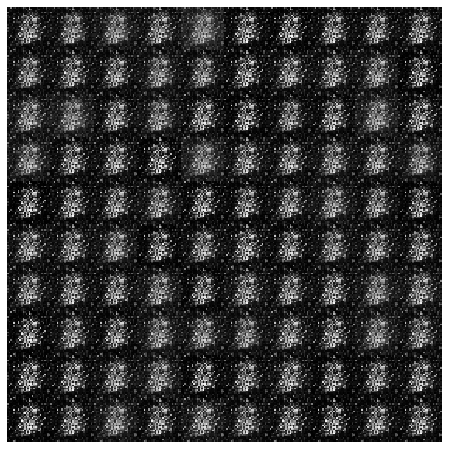

Epoch:   1
D Loss:  0.4489215016365051
G Loss:  1.5163133144378662
Epoch:   2
D Loss:  0.5628241896629333
G Loss:  2.084416389465332


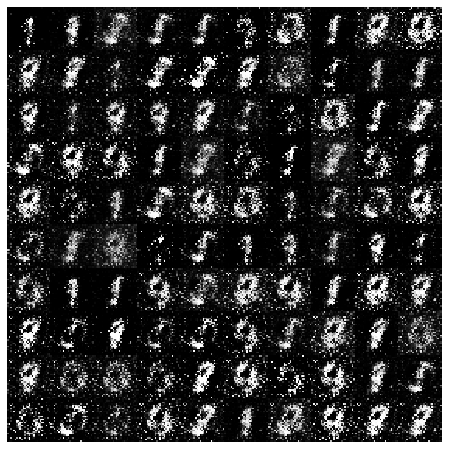

Epoch:   3
D Loss:  0.4862932562828064
G Loss:  1.5907809734344482
Epoch:   4
D Loss:  0.5135424137115479
G Loss:  1.1761444807052612


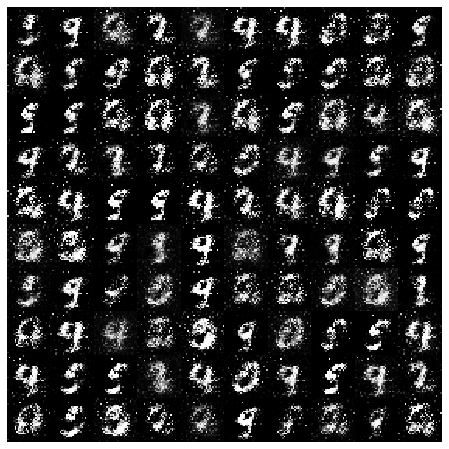

Epoch:   5
D Loss:  0.4577498137950897
G Loss:  1.732116460800171
Epoch:   6
D Loss:  0.46862661838531494
G Loss:  1.5623607635498047


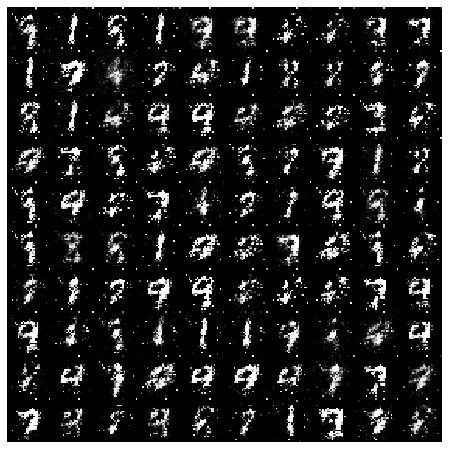

Epoch:   7
D Loss:  0.46180459856987
G Loss:  1.387479543685913
Epoch:   8
D Loss:  0.577277660369873
G Loss:  1.9596641063690186


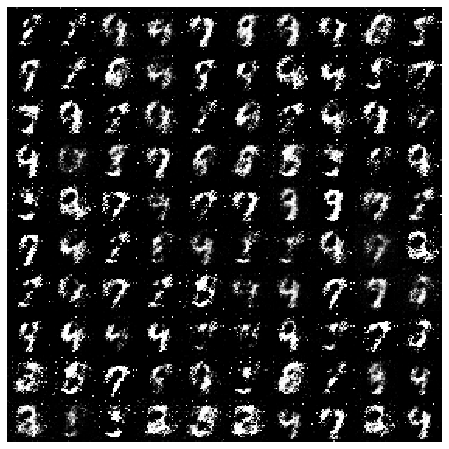

Epoch:   9
D Loss:  0.5320228338241577
G Loss:  1.5844441652297974
Epoch:   10
D Loss:  0.6090068817138672
G Loss:  0.6761516332626343


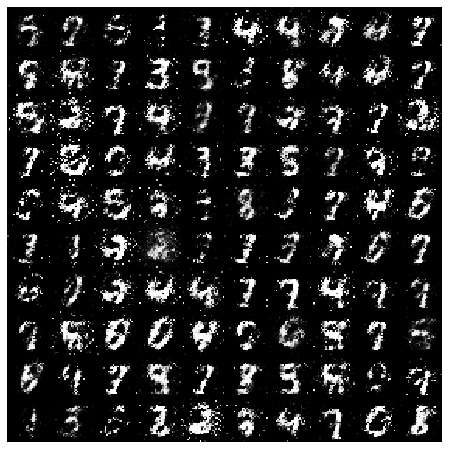

Epoch:   11
D Loss:  0.6644384264945984
G Loss:  0.6410567760467529
Epoch:   12
D Loss:  0.5612066388130188
G Loss:  1.2500066757202148


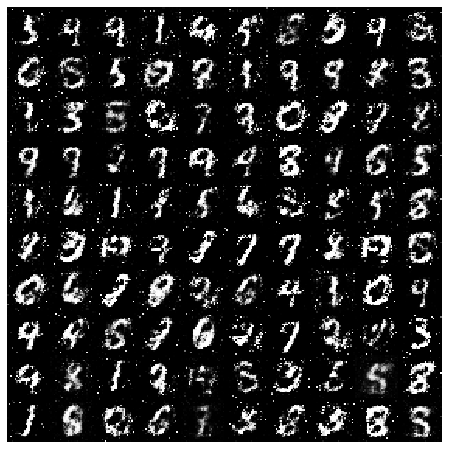

Epoch:   13
D Loss:  0.5726186037063599
G Loss:  1.1645183563232422
Epoch:   14
D Loss:  0.5834165215492249
G Loss:  1.0971688032150269


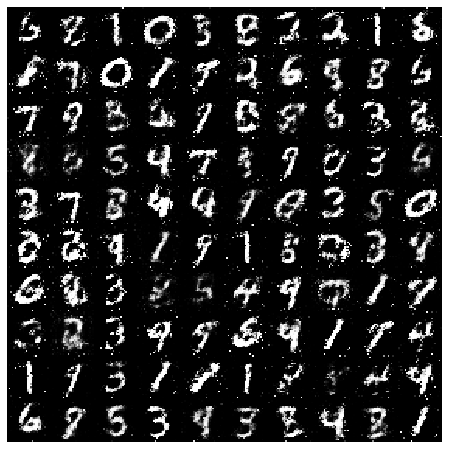

Epoch:   15
D Loss:  0.6044723987579346
G Loss:  0.6972523331642151
Epoch:   16
D Loss:  0.5935384035110474
G Loss:  0.9934397339820862


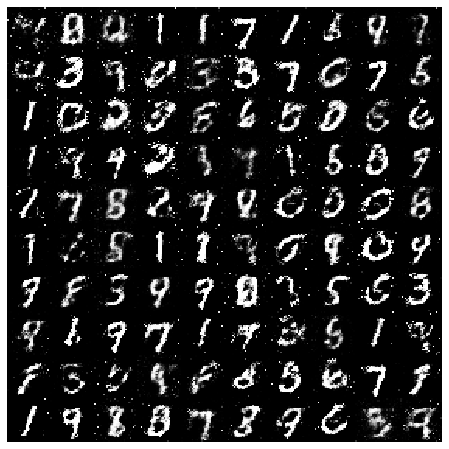

Epoch:   17
D Loss:  0.6311772465705872
G Loss:  0.8090499639511108
Epoch:   18
D Loss:  0.6109861731529236
G Loss:  0.8468968868255615


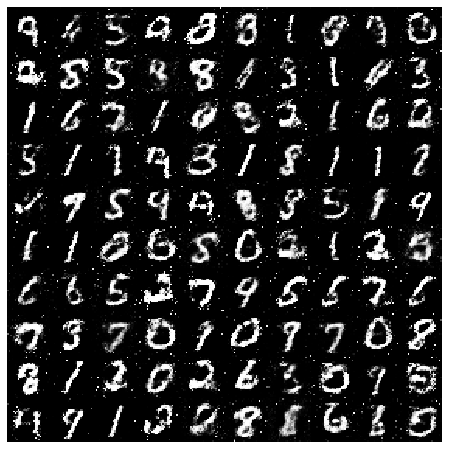

Epoch:   19
D Loss:  0.6051464676856995
G Loss:  1.0129053592681885
Epoch:   20
D Loss:  0.6219176054000854
G Loss:  0.7561090588569641


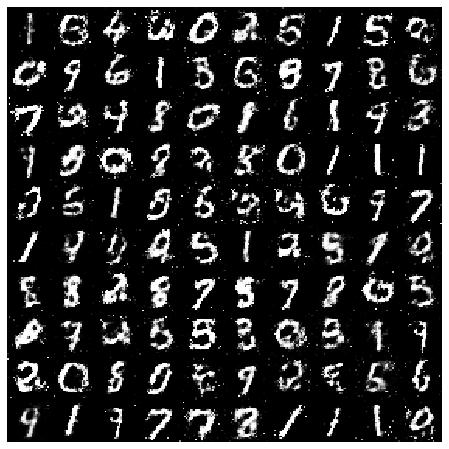

Epoch:   21
D Loss:  0.6088213920593262
G Loss:  1.1959295272827148
Epoch:   22
D Loss:  0.6037883758544922
G Loss:  0.8946166038513184


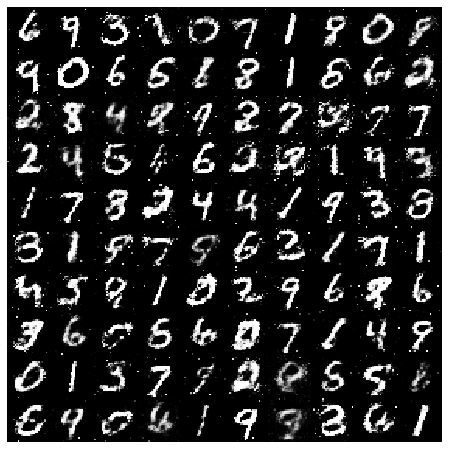

Epoch:   23
D Loss:  0.6306564211845398
G Loss:  0.796539843082428
Epoch:   24
D Loss:  0.636187732219696
G Loss:  0.7118443846702576


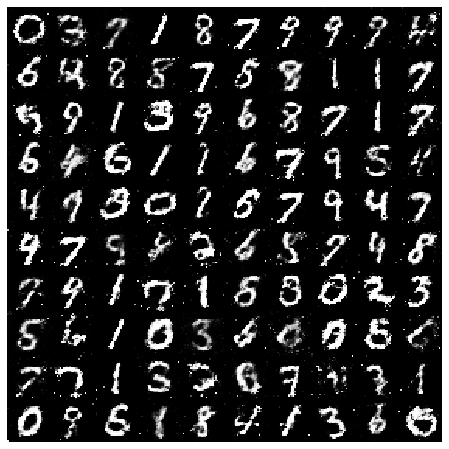

Epoch:   25
D Loss:  0.6055384278297424
G Loss:  0.9322479367256165
Epoch:   26
D Loss:  0.60735023021698
G Loss:  0.8587592840194702


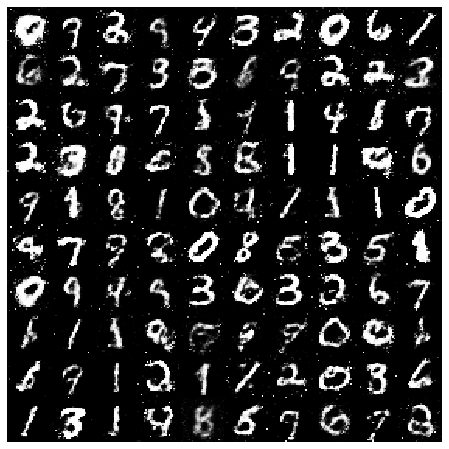

Epoch:   27
D Loss:  0.6629509925842285
G Loss:  1.2912566661834717
Epoch:   28
D Loss:  0.6210831999778748
G Loss:  0.8457306027412415


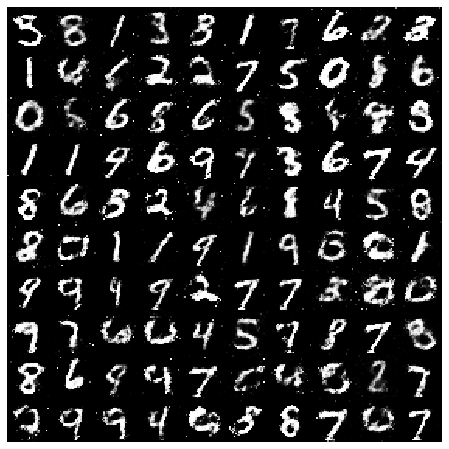

Epoch:   29
D Loss:  0.6152329444885254
G Loss:  0.927770733833313
Epoch:   30
D Loss:  0.6507171392440796
G Loss:  0.8220610618591309


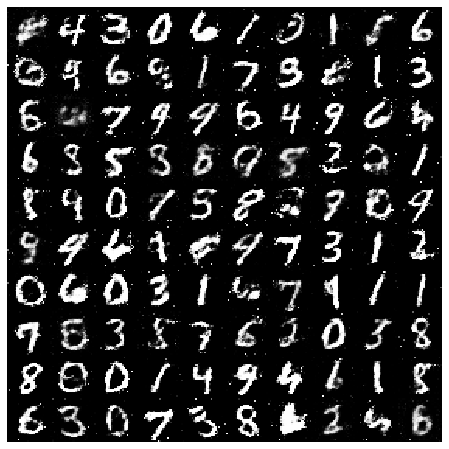

Epoch:   31
D Loss:  0.6133212447166443
G Loss:  0.836543083190918
Epoch:   32
D Loss:  0.6700763702392578
G Loss:  0.5834434032440186


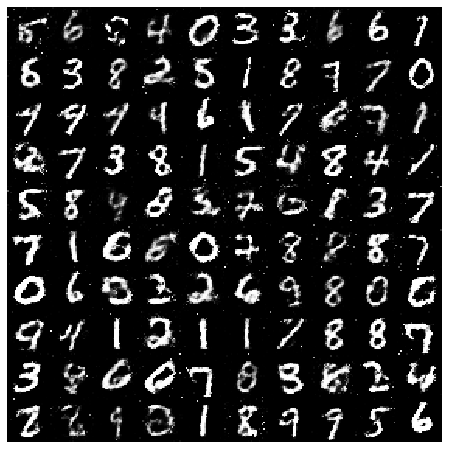

Epoch:   33
D Loss:  0.6635377407073975
G Loss:  0.6319459676742554
Epoch:   34
D Loss:  0.6266709566116333
G Loss:  1.018751621246338


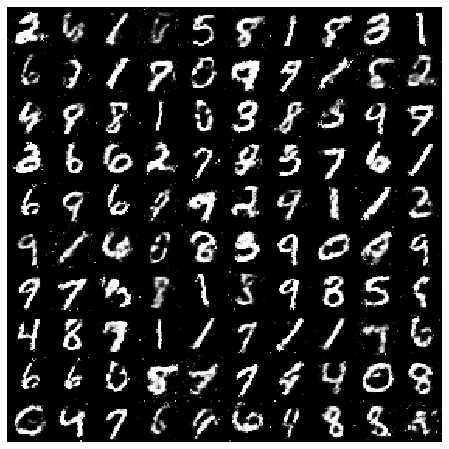

Epoch:   35
D Loss:  0.6200366020202637
G Loss:  0.8253906965255737
Epoch:   36
D Loss:  0.6310909390449524
G Loss:  0.8894804120063782


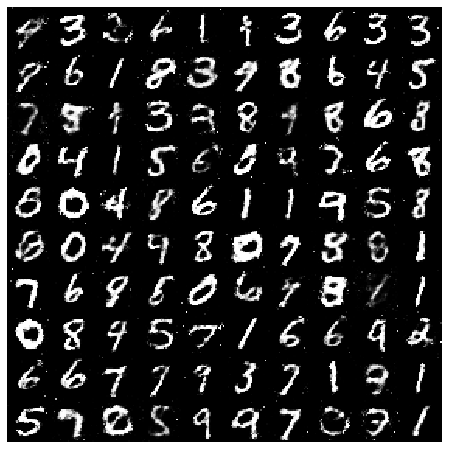

Epoch:   37
D Loss:  0.6336824893951416
G Loss:  0.9298768639564514
Epoch:   38
D Loss:  0.6143511533737183
G Loss:  0.9975206255912781


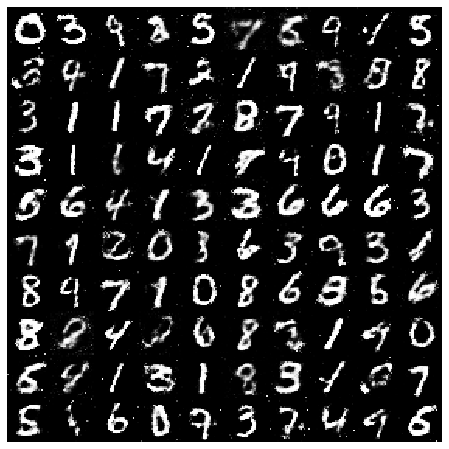

Epoch:   39
D Loss:  0.5949361324310303
G Loss:  0.837303638458252
Epoch:   40
D Loss:  0.6227236986160278
G Loss:  1.1127419471740723


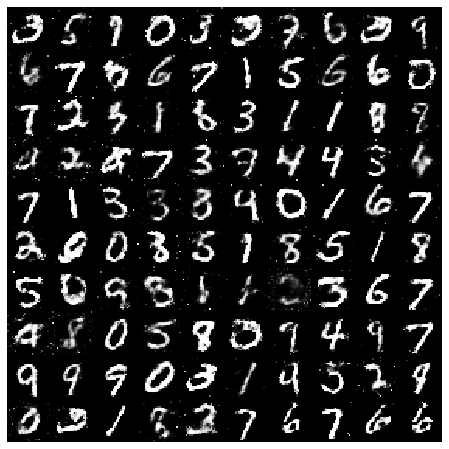

Epoch:   41
D Loss:  0.6030306816101074
G Loss:  0.9116156101226807
Epoch:   42
D Loss:  0.6076244115829468
G Loss:  1.062339186668396


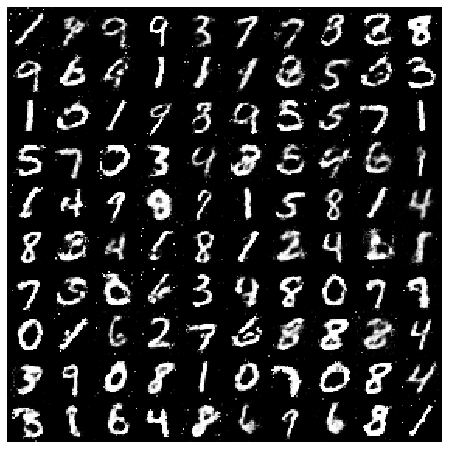

Epoch:   43
D Loss:  0.6178107261657715
G Loss:  1.0887237787246704
Epoch:   44
D Loss:  0.6464685201644897
G Loss:  1.0294015407562256


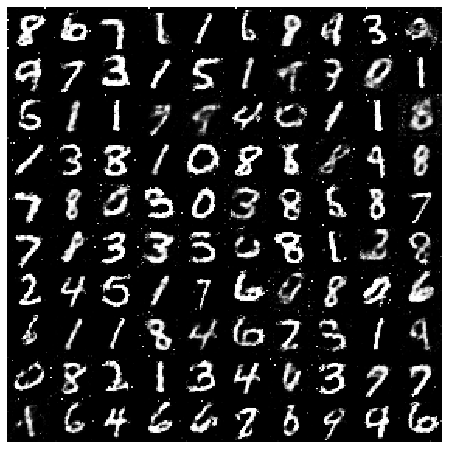

Epoch:   45
D Loss:  0.61815345287323
G Loss:  0.7194260954856873
Epoch:   46
D Loss:  0.6152881383895874
G Loss:  0.9556179046630859


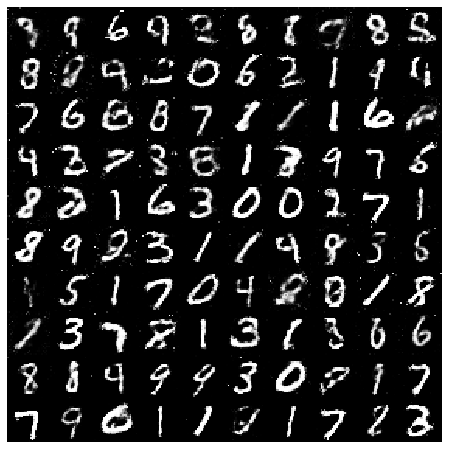

Epoch:   47
D Loss:  0.631949782371521
G Loss:  0.8420379161834717
Epoch:   48
D Loss:  0.6247215867042542
G Loss:  0.7442451119422913


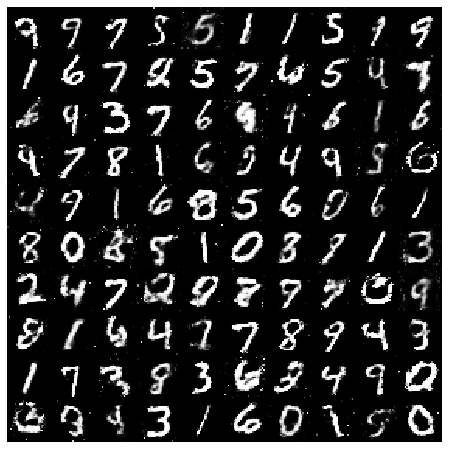

Epoch:   49
D Loss:  0.612046480178833
G Loss:  0.9161316156387329
Epoch:   50
D Loss:  0.6299790143966675
G Loss:  0.8921525478363037


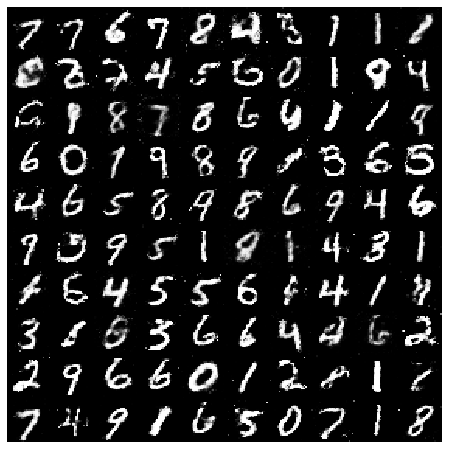

Epoch:   51
D Loss:  0.6362338662147522
G Loss:  1.285517692565918
Epoch:   52
D Loss:  0.7238122224807739
G Loss:  1.2949140071868896


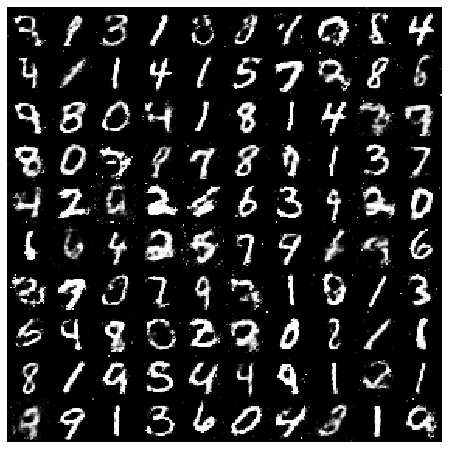

Epoch:   53
D Loss:  0.6033844947814941
G Loss:  0.8963948488235474
Epoch:   54
D Loss:  0.6179492473602295
G Loss:  0.8213564157485962


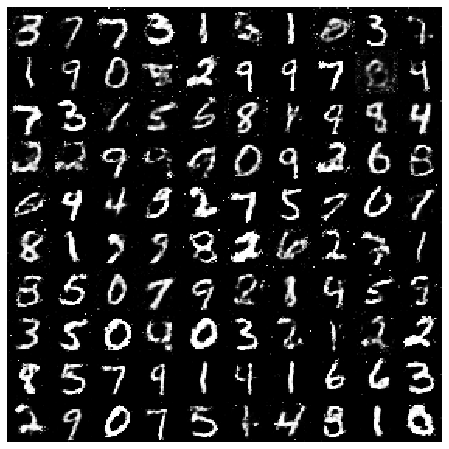

Epoch:   55
D Loss:  0.6049044132232666
G Loss:  0.7070650458335876
Epoch:   56
D Loss:  0.626537024974823
G Loss:  0.7645699381828308


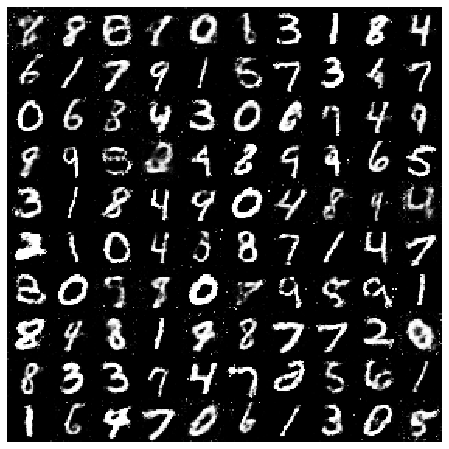

Epoch:   57
D Loss:  0.6394361257553101
G Loss:  0.8150390386581421
Epoch:   58
D Loss:  0.6154162287712097
G Loss:  0.9316065311431885


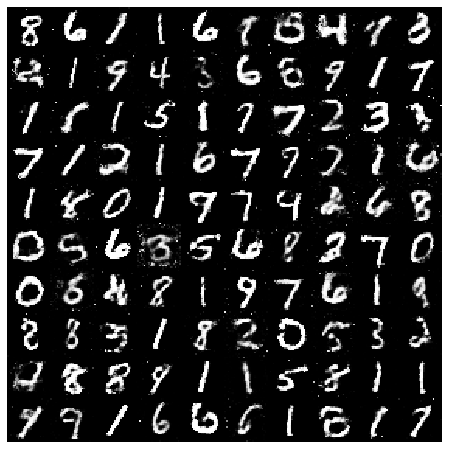

Epoch:   59
D Loss:  0.6043989062309265
G Loss:  1.0518821477890015
Epoch:   60
D Loss:  0.6131182909011841
G Loss:  1.0810388326644897


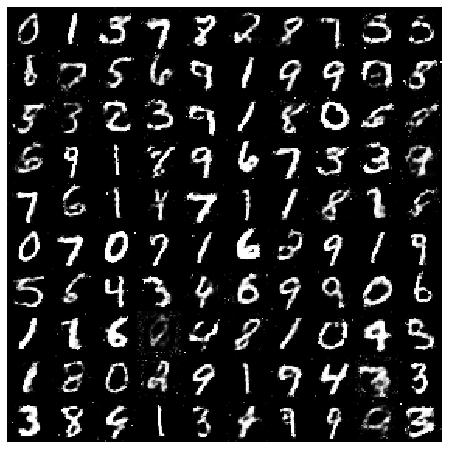

Epoch:   61
D Loss:  0.6026597023010254
G Loss:  1.1134670972824097
Epoch:   62
D Loss:  0.6067793369293213
G Loss:  0.8678548336029053


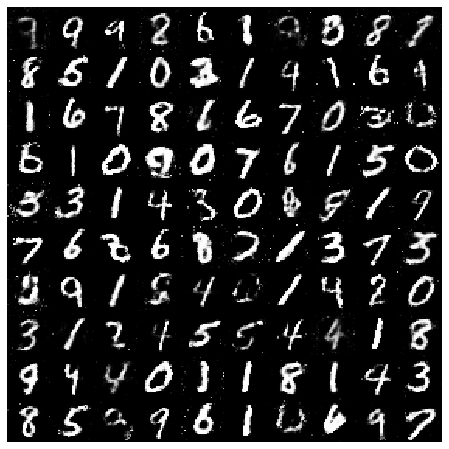

Epoch:   63
D Loss:  0.6685351133346558
G Loss:  1.457934021949768
Epoch:   64
D Loss:  0.6251852512359619
G Loss:  1.0035148859024048


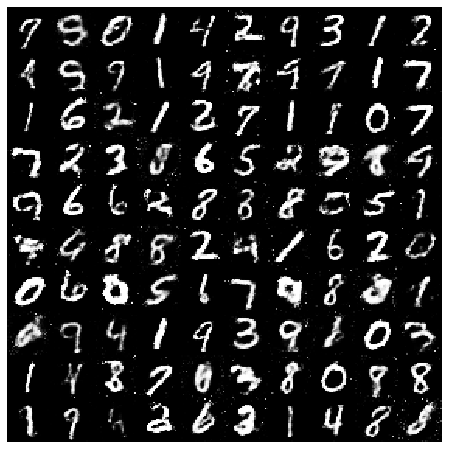

Epoch:   65
D Loss:  0.5844305753707886
G Loss:  0.9981739521026611
Epoch:   66
D Loss:  0.630324125289917
G Loss:  0.7498117685317993


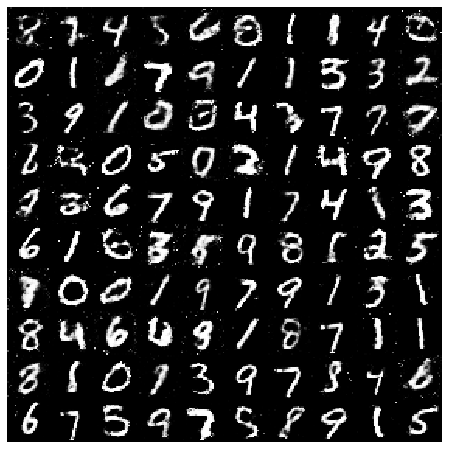

Epoch:   67
D Loss:  0.6040487289428711
G Loss:  0.8750102519989014
Epoch:   68
D Loss:  0.5550893545150757
G Loss:  1.1455851793289185


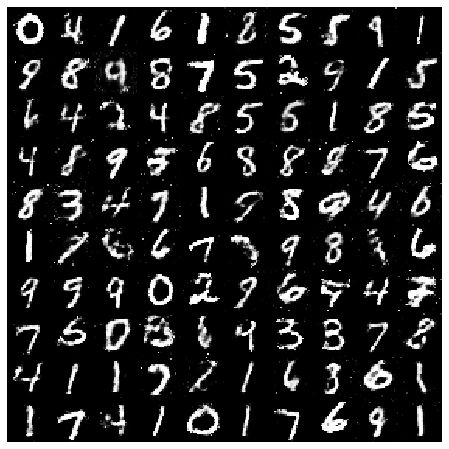

Epoch:   69
D Loss:  0.6013915538787842
G Loss:  1.079777717590332
Epoch:   70
D Loss:  0.6161278486251831
G Loss:  1.109573245048523


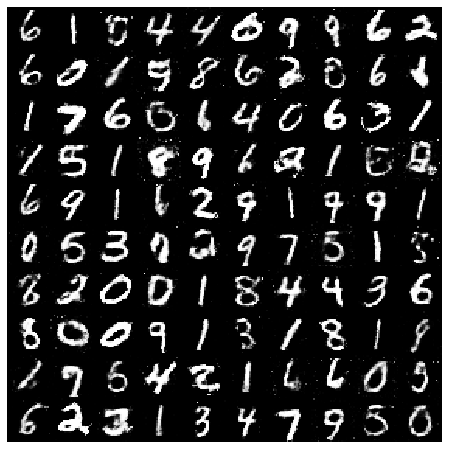

Epoch:   71
D Loss:  0.6483380794525146
G Loss:  0.6129586696624756
Epoch:   72
D Loss:  0.6196649670600891
G Loss:  1.0930423736572266


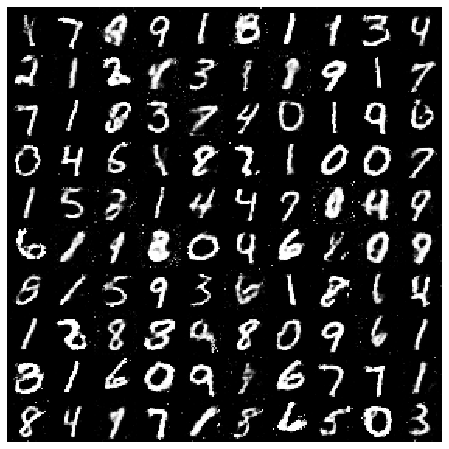

Epoch:   73
D Loss:  0.5670362710952759
G Loss:  0.9477211236953735
Epoch:   74
D Loss:  0.5702329874038696
G Loss:  0.9415689706802368


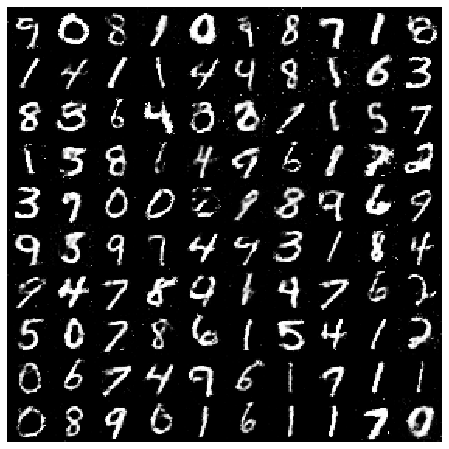

Epoch:   75
D Loss:  0.6140592694282532
G Loss:  1.1374750137329102
Epoch:   76
D Loss:  0.5884631276130676
G Loss:  1.0422062873840332


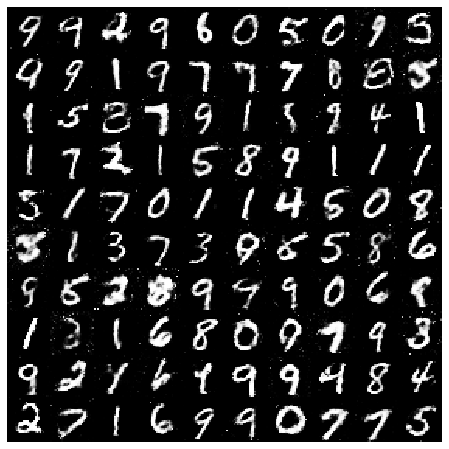

Epoch:   77
D Loss:  0.6171205043792725
G Loss:  0.783406674861908
Epoch:   78
D Loss:  0.5814879536628723
G Loss:  1.1368849277496338


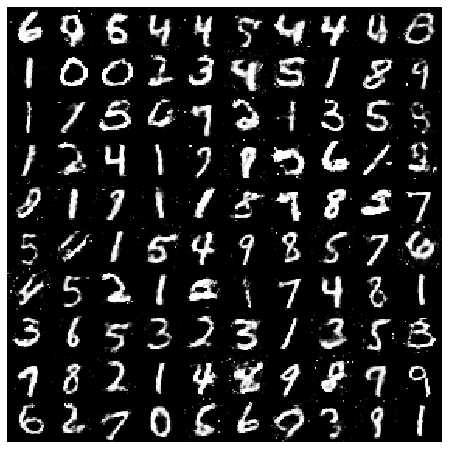

Epoch:   79
D Loss:  0.5981985926628113
G Loss:  0.9406455159187317
Epoch:   80
D Loss:  0.6154896020889282
G Loss:  0.8681221604347229


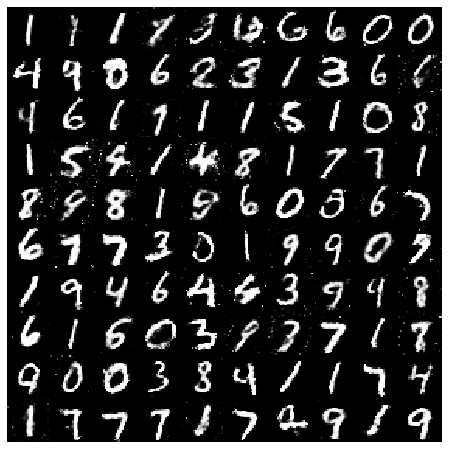

Epoch:   81
D Loss:  0.55506432056427
G Loss:  0.9280436038970947
Epoch:   82
D Loss:  0.6219014525413513
G Loss:  1.0342439413070679


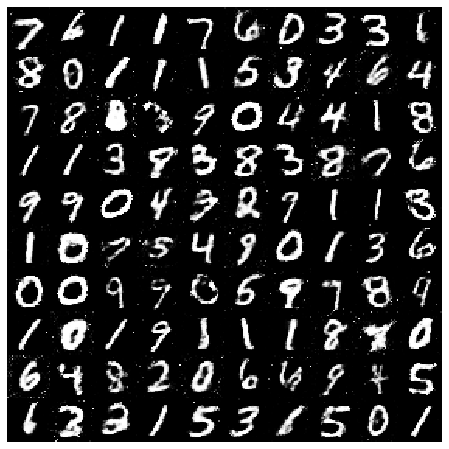

Epoch:   83
D Loss:  0.6146645545959473
G Loss:  0.9318627119064331
Epoch:   84
D Loss:  0.5671932697296143
G Loss:  1.130523681640625


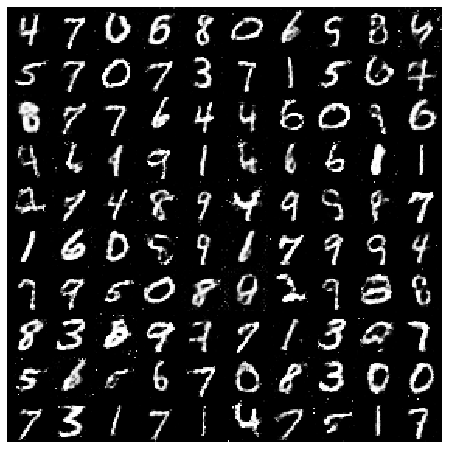

Epoch:   85
D Loss:  0.6259479522705078
G Loss:  0.8418741226196289
Epoch:   86
D Loss:  0.5915522575378418
G Loss:  0.8083465099334717


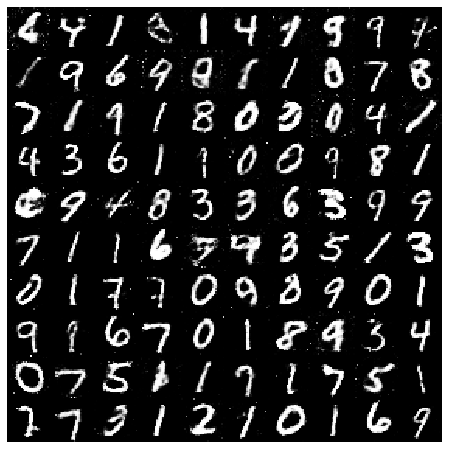

Epoch:   87
D Loss:  0.5671062469482422
G Loss:  0.9224927425384521
Epoch:   88
D Loss:  0.5714902877807617
G Loss:  1.0977773666381836


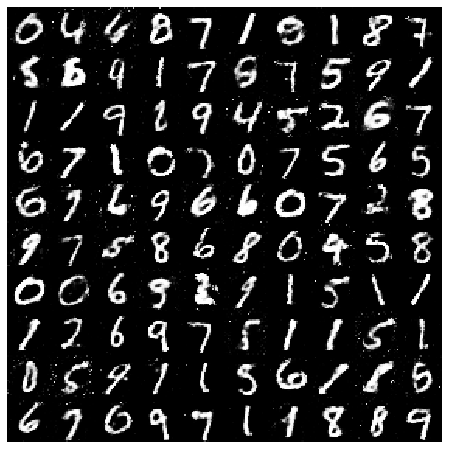

Epoch:   89
D Loss:  0.6062339544296265
G Loss:  1.1118898391723633
Epoch:   90
D Loss:  0.5841271281242371
G Loss:  1.02968168258667


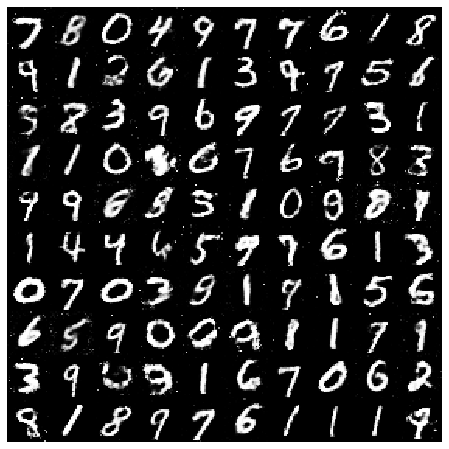

Epoch:   91
D Loss:  0.597327709197998
G Loss:  1.2503529787063599
Epoch:   92
D Loss:  0.634315550327301
G Loss:  0.8935393691062927


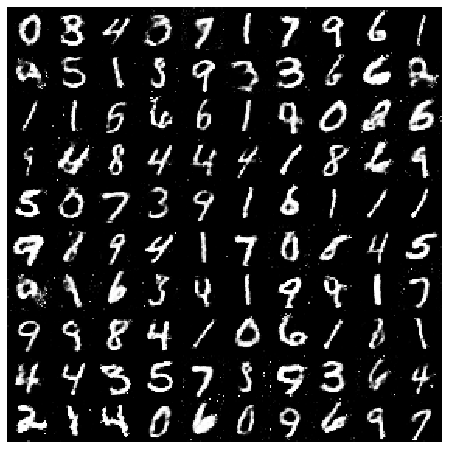

Epoch:   93
D Loss:  0.6014459133148193
G Loss:  0.7066382169723511
Epoch:   94
D Loss:  0.6236451864242554
G Loss:  1.166555404663086


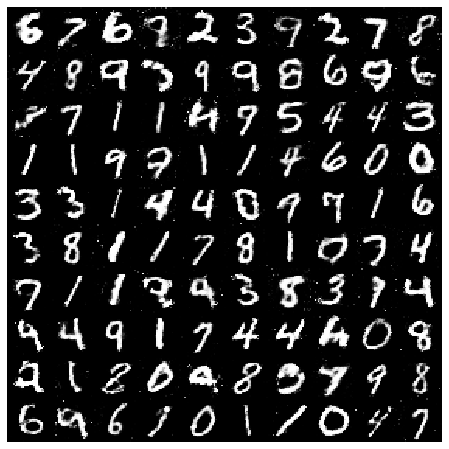

Epoch:   95
D Loss:  0.5930596590042114
G Loss:  1.2639501094818115
Epoch:   96
D Loss:  0.5861022472381592
G Loss:  1.1148760318756104


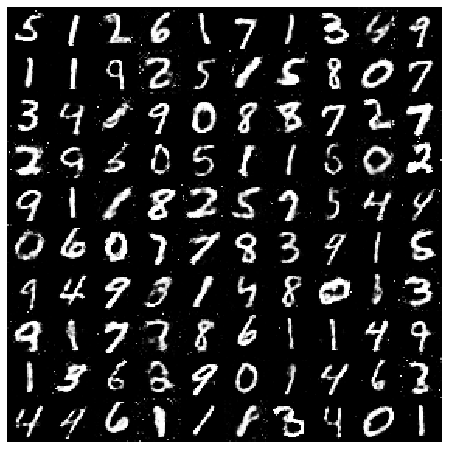

Epoch:   97
D Loss:  0.5682483911514282
G Loss:  1.0099315643310547
Epoch:   98
D Loss:  0.5977684855461121
G Loss:  1.1435248851776123


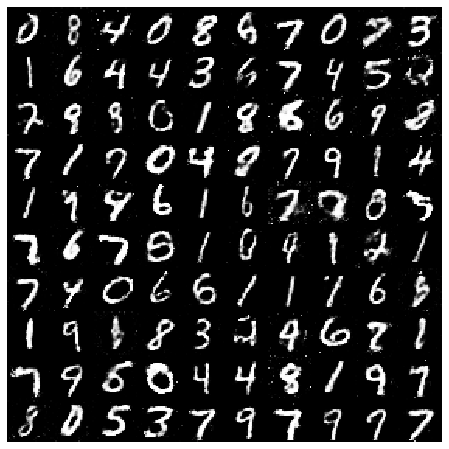

Epoch:   99
D Loss:  0.5812714695930481
G Loss:  0.881759524345398


In [16]:
## Training loop

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        
        # We set targets_real and targets_fake to non-binary values(soft and noisy labels).
        # This is a hack for stable training of GAN's.  
        # GAN hacks: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0))
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2))
                
        if is_cuda:
            targets_real = targets_real.cuda()
            targets_fake = targets_fake.cuda()
            images = images.cuda()
        
        ## D-STEP:
        ## First, clear the gradients of the Discriminator optimizer.
        ## Estimate logits_real by passing images through the Discriminator
        ## Generate fake_images by passing random noise through the Generator. Also, .detach() the fake images 
        ## as we don't compute the gradients of the Generator when optimizing Discriminator.
        ## fake_images = generator(noise(train_bs, noise_dim)).detach()
        ## Estimate logits_fake by passing the fake images through the Discriminator
        ## Compute the Discriminator loss by calling DLoss function.
        ## Compute the gradients by backpropagating through the computational graph. 
        ## Update the Discriminator parameters.
        
        
        ## G-STEP:
        ## clear the gradients of the Generator. 
        ## Generate fake images by passing random noise through the Generator. 
        ## Estimate logits_fake by passing the fake images through the Discriminator.
        ## compute the Generator loss by caling GLoss.
        ## compute the gradients by backpropagating through the computational graph.
        ## Update the Generator parameters. 
        
        # your code here
        
        optimizer_D.zero_grad()
        logits_real = discriminator(images)
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        logits_fake = discriminator(fake_images)
        discriminator_loss = DLoss(logits_real, logits_fake, targets_real, targets_fake)
        discriminator_loss.backward() 
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        fake_images = generator(noise(train_bs, noise_dim))
        logits_fake = discriminator(fake_images)
        generator_loss = GLoss(logits_fake, targets_real)
        generator_loss.backward()
        optimizer_G.step()
        

    print("Epoch:  ", epoch)
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        viz_batch = viz_batch[:100,:,:,:]
        viz_batch = viz_batch.reshape(-1,28*28).squeeze()
        viz_batch = viz_batch.reshape(10,10, 28,28).transpose(0,2,1,3).reshape(28*10,-1)

        plt.figure(figsize = (8,8))
        plt.axis('off')
        plt.imshow(viz_batch, cmap='gray')
        plt.show()

#### The assignment is graded both manually and using auto-graded testcases.